In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## Training Model

Index(['sperm_id', 'VSL_um_per_s', 'VCL_um_per_s', 'VAP_um_per_s', 'ALH_μm',
       'LIN_%', 'STR_%', 'BCF_Hz'],
      dtype='object')
Motility distribution:
 Motility_Grade
C    41
A    37
B    17
D    14
Name: count, dtype: int64
Label mapping: {'A': np.int64(0), 'B': np.int64(1), 'C': np.int64(2), 'D': np.int64(3)}

Training RandomForest...
RandomForest Accuracy: 0.955, F1-score: 0.956
Confusion Matrix:
 [[8 0 0 0]
 [0 3 0 0]
 [0 1 7 0]
 [0 0 0 3]]
Classification Report:
               precision    recall  f1-score   support

           A      1.000     1.000     1.000         8
           B      0.750     1.000     0.857         3
           C      1.000     0.875     0.933         8
           D      1.000     1.000     1.000         3

    accuracy                          0.955        22
   macro avg      0.938     0.969     0.948        22
weighted avg      0.966     0.955     0.956        22



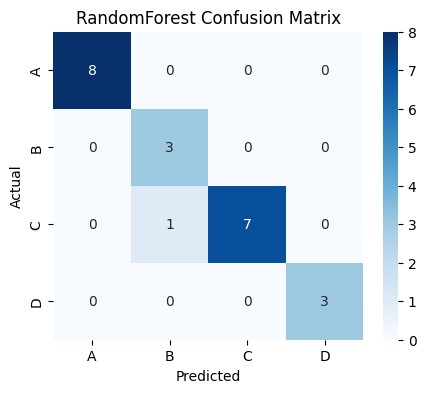


Training XGBoost...
XGBoost Accuracy: 0.955, F1-score: 0.956
Confusion Matrix:
 [[7 1 0 0]
 [0 3 0 0]
 [0 0 8 0]
 [0 0 0 3]]
Classification Report:
               precision    recall  f1-score   support

           A      1.000     0.875     0.933         8
           B      0.750     1.000     0.857         3
           C      1.000     1.000     1.000         8
           D      1.000     1.000     1.000         3

    accuracy                          0.955        22
   macro avg      0.938     0.969     0.948        22
weighted avg      0.966     0.955     0.956        22



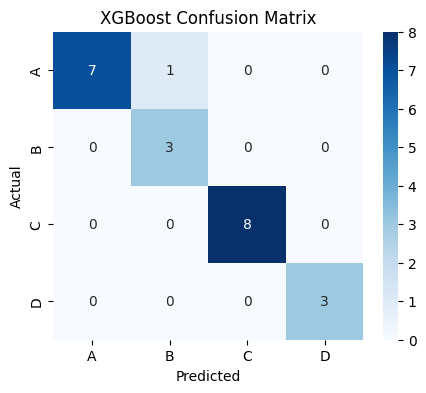


Training SVM...
SVM Accuracy: 0.636, F1-score: 0.596
Confusion Matrix:
 [[8 0 0 0]
 [2 0 1 0]
 [0 2 3 3]
 [0 0 0 3]]
Classification Report:
               precision    recall  f1-score   support

           A      0.800     1.000     0.889         8
           B      0.000     0.000     0.000         3
           C      0.750     0.375     0.500         8
           D      0.500     1.000     0.667         3

    accuracy                          0.636        22
   macro avg      0.512     0.594     0.514        22
weighted avg      0.632     0.636     0.596        22



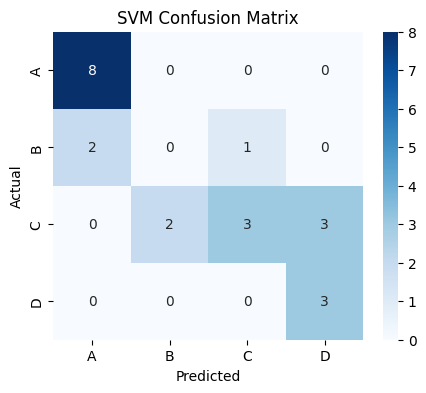

Best model saved: RandomForest


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ---------------- Load CASA CSV ----------------
CASA_FILE = "/Users/mano/Documents/AI in Medicine/Project/AI in Medicine/11_CASA_summary.csv"
df = pd.read_csv(CASA_FILE)

# Clean column names
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '') \
                       .str.replace('μm/s', 'um_per_s').str.replace('Hz', 'Hz')
print(df.columns)

# ---------------- Apply clinical motility thresholds ----------------
def assign_motility_grade(row):
    if row['VSL_um_per_s'] >= 25:
        return "A"  # rapid progressive
    elif 5 <= row['VSL_um_per_s'] < 25:
        return "B"  # non-linear progressive
    elif 0 < row['VSL_um_per_s'] < 5:
        return "C"  # non-progressive
    else:
        return "D"  # immotile

df['Motility_Grade'] = df.apply(assign_motility_grade, axis=1)
print("Motility distribution:\n", df['Motility_Grade'].value_counts())

# ---------------- Feature & Label Selection ----------------
FEATURES = ['VCL_um_per_s', 'VSL_um_per_s', 'VAP_um_per_s', 'LIN_%', 'STR_%', 'BCF_Hz']

# Ensure missing cols exist
for col in ['WOB', 'ALH_um']:
    if col not in df.columns:
        df[col] = 0.0

X = df[FEATURES].fillna(0).values
y = df['Motility_Grade'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ---------------- Train/Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Standardize features for SVM/XGB
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------- Train Models ----------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, eval_metric='mlogloss', random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    # Scale only for SVM/XGB
    X_tr = X_train_scaled if name in ["SVM", "XGBoost"] else X_train
    X_te = X_test_scaled if name in ["SVM", "XGBoost"] else X_test
    
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    
    acc = round(accuracy_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {"accuracy": acc, "f1_score": f1, "conf_matrix": cm}
    
    print(f"{name} Accuracy: {acc}, F1-score: {f1}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", 
          classification_report(y_test, y_pred, target_names=le.classes_, digits=3))
    
    # Plot confusion matrix (values already integers, no rounding needed)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ---------------- Save best model ----------------
best_model_name = max(results, key=lambda k: results[k]['f1_score'])
best_model = models[best_model_name]
joblib.dump(best_model, "motility_classifier.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
print(f"Best model saved: {best_model_name}")

## Grid Search (Systematic Search)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_est

## Randomized Search (Faster)

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

rand_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                 n_iter=50, cv=5, scoring='f1_weighted',
                                 n_jobs=-1, verbose=2, random_state=42)

rand_search.fit(X_train, y_train)

print("Best parameters:", rand_search.best_params_)
print("Best F1-score:", rand_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=300; 

### Tuned RF

Label mapping: {'A': np.int64(0), 'B': np.int64(1), 'C': np.int64(2), 'D': np.int64(3)}
Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test Accuracy: 0.955, F1-score: 0.956
Confusion Matrix:
 [[8 0 0 0]
 [0 3 0 0]
 [0 1 7 0]
 [0 0 0 3]]
Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.75      1.00      0.86         3
           C       1.00      0.88      0.93         8
           D       1.00      1.00      1.00         3

    accuracy                           0.95        22
   macro avg       0.94      0.97      0.95        22
weighted avg       0.97      0.95      0.96        22



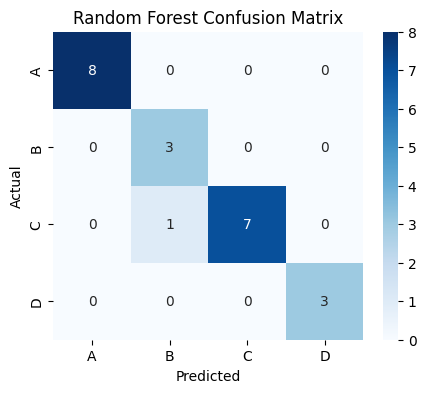

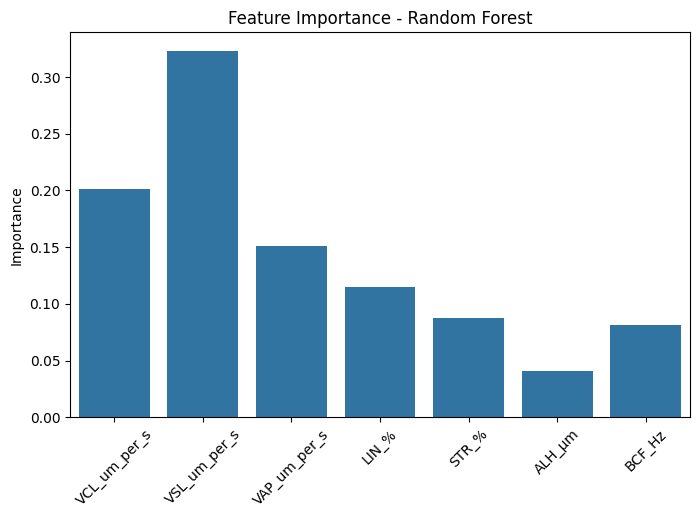

Tuned Random Forest model saved!


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ---------------- Load CASA CSV ----------------
CASA_FILE = "/Users/mano/Documents/AI in Medicine/Project/AI in Medicine/11_CASA_summary.csv"
df = pd.read_csv(CASA_FILE)

# Clean column names
df.columns = df.columns.str.replace(' ', '_') \
                       .str.replace('(', '') \
                       .str.replace(')', '') \
                       .str.replace('μm/s', 'um_per_s') \
                       .str.replace('Hz', 'Hz')

# ---------------- Apply clinical motility thresholds ----------------
def assign_motility_grade(row):
    if row['VSL_um_per_s'] >= 25:
        return "A"  # rapid progressive
    elif 5 <= row['VSL_um_per_s'] < 25:
        return "B"  # non-linear progressive
    elif 0 < row['VSL_um_per_s'] < 5:
        return "C"  # non-progressive
    else:
        return "D"  # immotile

df['Motility_Grade'] = df.apply(assign_motility_grade, axis=1)

# ---------------- Features & Labels ----------------
FEATURES = ['VCL_um_per_s', 'VSL_um_per_s', 'VAP_um_per_s',
            'LIN_%', 'STR_%', 'ALH_μm', 'BCF_Hz']  # removed 'WOB' which is missing

X = df[FEATURES].fillna(0).values
y = df['Motility_Grade'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# ---------------- Train/Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# ---------------- Feature Scaling ----------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------- Hyperparameter Tuning ----------------
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# ---------------- Evaluate on Test Set ----------------
y_pred = best_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {acc:.3f}, F1-score: {f1:.3f}")
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ---------------- Feature Importance ----------------
importances = best_rf.feature_importances_
plt.figure(figsize=(8,5))
sns.barplot(x=FEATURES, y=importances)
plt.title("Feature Importance - Random Forest")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

# ---------------- Save model & scaler ----------------
joblib.dump(best_rf, "motility_classifier_tuned.pkl")
joblib.dump(scaler, "feature_scaler.pkl")
print("Tuned Random Forest model saved!")

## Testing the Model

In [9]:
import pandas as pd
import joblib

# ---------------- Paths ----------------
MODEL_FILE = "motility_classifier_tuned.pkl"  # your tuned RF
SCALER_FILE = "feature_scaler.pkl"
NEW_CASA_FILE = "/Users/mano/Documents/AI in Medicine/Project/AI in Medicine/82_CASA_summary.csv"

# ---------------- Load model & scaler ----------------
model = joblib.load(MODEL_FILE)
scaler = joblib.load(SCALER_FILE)

# ---------------- Load new CASA data ----------------
df_new = pd.read_csv(NEW_CASA_FILE)

# Clean column names to match training data
df_new.columns = df_new.columns.str.replace(' ', '_')\
                               .str.replace('(', '')\
                               .str.replace(')', '')\
                               .str.replace('μm/s', 'um_per_s')\
                               .str.replace('Hz', 'Hz')

print("Columns in new dataset:", df_new.columns)

# ---------------- Define features used by saved model ----------------
# Get features from the model input
# RF was trained on 6 features (without ALH_um)
# Rename ALH column to match training
df_new.rename(columns={'ALH_μm': 'ALH_um'}, inplace=True)

# Include all 7 features used in training
FEATURES_RF = ['VCL_um_per_s', 'VSL_um_per_s', 'VAP_um_per_s',
               'LIN_%', 'STR_%', 'ALH_um', 'BCF_Hz']

# Check if all required features exist
missing_features = [f for f in FEATURES_RF if f not in df_new.columns]
if missing_features:
    raise ValueError(f"Missing features in new dataset: {missing_features}")

# ---------------- Prepare data ----------------
X_new = df_new[FEATURES_RF].fillna(0).values

# Scaling is optional for RF, but you can use scaler if needed
# X_new_scaled = scaler.transform(X_new)

# ---------------- Predict ----------------
y_pred_encoded = model.predict(X_new)  # RF works with unscaled input
# If you want probabilities:
y_pred_proba = model.predict_proba(X_new)

# ---------------- Map encoded labels back to grades ----------------
# Assuming you saved the label encoder or know the mapping:
label_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
y_pred = [label_mapping[i] for i in y_pred_encoded]

# ---------------- Add predictions to dataframe ----------------
df_new['Predicted_Motility'] = y_pred

# ---------------- Round off CASA features ----------------
# Round CASA features to 2 decimal places (you can change to 1 or 3 if needed)
df_new[FEATURES_RF] = df_new[FEATURES_RF].round(2)

# ---------------- Save predictions ----------------
df_new.to_csv("82_CASA_new_predictions.csv", index=False)
print("Predictions saved to 82_CASA_new_predictions.csv")

# Display sperm_id, rounded features, and prediction
print(df_new[['sperm_id'] + FEATURES_RF + ['Predicted_Motility']])

df['Motility_Grade'] = df.apply(assign_motility_grade, axis=1)
print("Motility distribution:\n", df['Motility_Grade'].value_counts())

Columns in new dataset: Index(['sperm_id', 'VSL_um_per_s', 'VCL_um_per_s', 'VAP_um_per_s', 'ALH_μm',
       'LIN_%', 'STR_%', 'BCF_Hz'],
      dtype='object')
Predictions saved to 82_CASA_new_predictions.csv
              sperm_id  VCL_um_per_s  VSL_um_per_s  VAP_um_per_s  LIN_%  \
0    ID_0_Normal Sperm          3.89          0.33          1.89   8.57   
1   ID_1_Pinhead Sperm          1.73          0.06          0.83   3.70   
2    ID_2_Normal Sperm          3.67          1.19          2.33  32.53   
3    ID_3_Normal Sperm          4.85          0.76          2.17  15.69   
4    ID_4_Normal Sperm          1.79          0.00          0.69   0.00   
..                 ...           ...           ...           ...    ...   
64  ID_77_Normal Sperm         36.21         15.00          9.14  41.42   
65  ID_78_Normal Sperm          0.00          0.00          0.00   0.00   
66  ID_79_Normal Sperm        105.50         20.47         79.81  19.40   
67  ID_80_Normal Sperm        131.78      

## **SHAP**

In [11]:
import os
import numpy as np
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# ---------------- User params ----------------
MODEL_FILE = "motility_classifier_tuned.pkl"   # tuned RF
NEW_CASA_FILE = "/Users/mano/Documents/AI in Medicine/Project/AI in Medicine/11_CASA_summary.csv"
FEATURES_RF = ['VCL_um_per_s', 'VSL_um_per_s', 'VAP_um_per_s', 'LIN_%', 'STR_%', 'ALH_um', 'BCF_Hz']
OUTPUT_DIR = "xai_outputs"
SAMPLE_IDS = [0, 1, 2]   # indices of rows to create waterfall plots for
N_TOP_FEATURES = len(FEATURES_RF)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------- Load model and data ----------------
model = joblib.load(MODEL_FILE)
df = pd.read_csv(NEW_CASA_FILE)

# Clean column names similar to training
df.columns = df.columns.str.replace(' ', '_') \
                       .str.replace('(', '') \
                       .str.replace(')', '') \
                       .str.replace('μm/s', 'um_per_s') \
                       .str.replace('Hz', 'Hz')

# rename ALH if necessary (handles ALH_μm vs ALH_um)
if 'ALH_μm' in df.columns and 'ALH_um' not in df.columns:
    df.rename(columns={'ALH_μm': 'ALH_um'}, inplace=True)

# Ensure features exist
missing = [f for f in FEATURES_RF if f not in df.columns]
if missing:
    raise ValueError(f"Missing features in dataframe: {missing}")

# Prepare X (no scaling required for RF; SHAP works with raw features used for model)
X_df = df[FEATURES_RF].fillna(0)
X = X_df.values  # shape (n_samples, n_features)

# ---------------- Create SHAP explainer and values ----------------
explainer = shap.TreeExplainer(model)  # best for tree models
raw_shap = explainer.shap_values(X)   # can be list, ndarray, or Explanation depending on shap version

# Normalize raw_shap into consistent numpy form and compute means
# Cases we handle:
#  - list of arrays: [ (n_samples,n_features), ... ] (one per class)
#  - ndarray: either (n_samples, n_features) OR (n_samples, n_features, n_classes)
#  - Explanation object: has .values which may be 2D or 3D

# Unwrap Explanation objects
if hasattr(raw_shap, "values"):
    sv = raw_shap.values
else:
    sv = raw_shap

# Convert to numpy-friendly shapes and compute per-class & aggregated importances
if isinstance(sv, list):
    # list of arrays, each (n_samples, n_features)
    per_class_mean_abs = []
    for class_idx, arr in enumerate(sv):
        arr = np.asarray(arr)
        if arr.ndim != 2:
            raise ValueError(f"unexpected shap array shape for class {class_idx}: {arr.shape}")
        # mean over samples -> (n_features,)
        per_class_mean_abs.append(np.mean(np.abs(arr), axis=0))
    per_class_mean_abs = np.vstack(per_class_mean_abs)  # shape (n_classes, n_features)
    mean_abs_shap_by_feature = np.mean(per_class_mean_abs, axis=0)  # (n_features,)
    # keep per_class_mean_abs for per-class plotting
elif isinstance(sv, np.ndarray):
    if sv.ndim == 3:
        # shape (n_samples, n_features, n_classes)
        # compute mean absolute over samples -> (n_features, n_classes)
        feat_by_class = np.mean(np.abs(sv), axis=0)  # (n_features, n_classes)
        per_class_mean_abs = feat_by_class.T        # (n_classes, n_features)
        mean_abs_shap_by_feature = np.mean(per_class_mean_abs, axis=0)  # (n_features,)
    elif sv.ndim == 2:
        # binary/single-output: shape (n_samples, n_features)
        per_class_mean_abs = np.expand_dims(np.mean(np.abs(sv), axis=0), axis=0)  # (1, n_features)
        mean_abs_shap_by_feature = per_class_mean_abs.ravel()
    else:
        raise ValueError(f"Unhandled shap ndarray dimensionality: {sv.shape}")
else:
    raise ValueError("Unhandled type for shap values: %s" % type(sv))

# Sanity-check shapes
mean_abs_shap_by_feature = np.asarray(mean_abs_shap_by_feature).ravel()
if mean_abs_shap_by_feature.shape[0] != len(FEATURES_RF):
    # If mismatch, try transpose / squeeze; otherwise fallback to safe behavior
    raise ValueError(f"SHAP-derived feature vector length {mean_abs_shap_by_feature.shape[0]} "
                     f"does not match FEATURES_RF length {len(FEATURES_RF)}")

print("Computed mean |SHAP| per feature shape:", mean_abs_shap_by_feature.shape)

# ---------------- Save feature importance CSV ----------------
feat_imp_df = pd.DataFrame({
    "feature": FEATURES_RF,
    "mean_abs_shap": mean_abs_shap_by_feature
}).sort_values("mean_abs_shap", ascending=False)
feat_imp_df.to_csv(os.path.join(OUTPUT_DIR, "shap_feature_importance.csv"), index=False)
print("Saved:", os.path.join(OUTPUT_DIR, "shap_feature_importance.csv"))

# ---------------- Global bar plot (mean |SHAP|) ----------------
plt.figure(figsize=(8, max(4, 0.5 * len(FEATURES_RF))))
sns.barplot(x="mean_abs_shap", y="feature", data=feat_imp_df, palette="viridis")
plt.title("Mean |SHAP| Feature Importance (global)")
plt.xlabel("Mean |SHAP|")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "shap_bar_mean_abs.png"), dpi=200)
plt.close()
print("Saved:", os.path.join(OUTPUT_DIR, "shap_bar_mean_abs.png"))

# ---------------- Per-class SHAP summary plots (beeswarm) ----------------
# For list form, we can use each sv[class] array; for ndarray form use sv[:,:,class]
n_classes = per_class_mean_abs.shape[0]
print(f"Detected {n_classes} classes for SHAP plots.")
for class_idx in range(n_classes):
    plt.figure(figsize=(8,6))
    try:
        if isinstance(raw_shap, list):
            shap.summary_plot(raw_shap[class_idx], X_df, show=False)
        else:
            # raw_shap was ndarray or Explanation -> get a 2D array for this class
            if isinstance(raw_shap, np.ndarray) and raw_shap.ndim == 3:
                class_shap_arr = raw_shap[:, :, class_idx]  # (n_samples, n_features)
                shap.summary_plot(class_shap_arr, X_df, show=False)
            elif hasattr(raw_shap, "values") and raw_shap.values.ndim == 3:
                # Explanation object with .values shape (n_samples,n_features,n_classes)
                class_shap_arr = raw_shap.values[:, :, class_idx]
                shap.summary_plot(class_shap_arr, X_df, show=False)
            else:
                # fallback: use mean abs bar only
                plt.text(0.5,0.5,"No beeswarm available for this shape",ha='center')
        plt.title(f"SHAP summary (class {class_idx})")
        plt.tight_layout()
        out = os.path.join(OUTPUT_DIR, f"shap_summary_class_{class_idx}.png")
        plt.savefig(out, dpi=200)
        plt.close()
        print("Saved:", out)
    except Exception as e:
        plt.close()
        print(f"Could not create SHAP summary for class {class_idx}: {e}")

# ---------------- Local explanations (waterfall) for sample tracks ----------------
# predicted class per sample (model.classes_ may be encoded ints)
preds_encoded = model.predict(X)  # numeric encoded labels
# If you want to map to 'A','B','C','D' adapt mapping accordingly
label_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}  # adjust if needed

for idx in SAMPLE_IDS:
    if idx < 0 or idx >= X.shape[0]:
        print(f"Skipping sample idx {idx} (out of range)")
        continue

    predicted_class = int(preds_encoded[idx])
    # extract local shap vector for that sample & class
    if isinstance(raw_shap, list):
        local_shap = np.asarray(raw_shap[predicted_class][idx])  # (n_features,)
    elif isinstance(raw_shap, np.ndarray) and raw_shap.ndim == 3:
        local_shap = np.asarray(raw_shap[idx, :, predicted_class])  # (n_features,)
    elif hasattr(raw_shap, "values") and raw_shap.values.ndim == 3:
        local_shap = np.asarray(raw_shap.values[idx, :, predicted_class])
    else:
        raise ValueError("Unable to extract local SHAP for sample")

    # base value
    base_value = None
    if hasattr(explainer, "expected_value"):
        ev = explainer.expected_value
        if isinstance(ev, (list, tuple, np.ndarray)):
            try:
                base_value = float(ev[predicted_class])
            except Exception:
                # fallback: if ev is array per class or single
                base_value = float(np.array(ev).ravel()[0])
        else:
            base_value = float(ev)
    else:
        base_value = 0.0

    # create waterfall plot or fallback bar
    try:
        plt.figure(figsize=(6,5))
        # Try modern waterfall if available
        try:
            # shap.plots.waterfall accepts Explanation objects; build one if needed
            # We'll attempt legacy waterfall for reliability
            shap.plots._waterfall.waterfall_legacy(base_value, local_shap, feature_names=FEATURES_RF, show=False)
        except Exception:
            # fallback horizontal bar of top contributions
            s = pd.Series(local_shap, index=FEATURES_RF).abs().sort_values(ascending=False)
            topk = s.head(min(6, len(s)))
            vals = pd.Series(local_shap, index=FEATURES_RF).loc[topk.index]
            plt.barh(vals.index[::-1], vals.values[::-1])
            plt.xlabel("SHAP value")
            plt.title(f"Top SHAP contributions (idx={idx}, class={predicted_class})")
        out = os.path.join(OUTPUT_DIR, f"shap_waterfall_track_{idx}.png")
        plt.tight_layout()
        plt.savefig(out, dpi=200)
        plt.close()
        print("Saved local explanation:", out)
    except Exception as e:
        print("Failed to save local explanation for idx", idx, ":", e)

# ---------------- Save interpretation template ----------------
interp_lines = []
interp_lines.append("XAI Interpretation \n")
interp_lines.append("Feature ranking (mean |SHAP|) — global aggregated across classes:\n")
for _, r in feat_imp_df.iterrows():
    interp_lines.append(f"{r['feature']}: {r['mean_abs_shap']:.4f}")

interp_lines.append("\nClinical interpretation examples (adapt to your dataset):\n")
interp_lines.append("- Progressive motility (Grade A) is typically associated with high VSL (straight-line velocity) and high LIN (linearity).")
interp_lines.append("- High VCL but low VSL/LIN often indicates curvilinear or non-linear movement (Grade B).")
interp_lines.append("- Very low VSL (<5 μm/s) corresponds to non-progressive (Grade C) or immotile (Grade D) sperm.")
interp_lines.append("- High ALH with low STR may indicate vigorous but non-linear motion (often seen in Grade B).")
interp_lines.append("- BCF contributes to distinguishing motility vigor and may correlate with VCL/ALH patterns.")

with open(os.path.join(OUTPUT_DIR, "xai_text_interpretation.txt"), "w") as f:
    f.write("\n".join(interp_lines))

print("Saved interpretation:", os.path.join(OUTPUT_DIR, "xai_text_interpretation.txt"))
print("All XAI outputs saved to:", OUTPUT_DIR)

/opt/homebrew/Cellar/jupyterlab/4.4.7/libexec/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/1d/v3xlkt_j28l0r070b4ls10440000gn/T/ipykernel_82423/2634246034.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="mean_abs_shap", y="feature", data=feat_imp_df, palette="viridis")


Computed mean |SHAP| per feature shape: (7,)
Saved: xai_outputs/shap_feature_importance.csv
Saved: xai_outputs/shap_bar_mean_abs.png
Detected 4 classes for SHAP plots.
Saved: xai_outputs/shap_summary_class_0.png
Saved: xai_outputs/shap_summary_class_1.png
Saved: xai_outputs/shap_summary_class_2.png
Saved: xai_outputs/shap_summary_class_3.png
Saved local explanation: xai_outputs/shap_waterfall_track_0.png
Saved local explanation: xai_outputs/shap_waterfall_track_1.png
Saved local explanation: xai_outputs/shap_waterfall_track_2.png
Saved interpretation: xai_outputs/xai_text_interpretation.txt
All XAI outputs saved to: xai_outputs


## **LIME**

In [12]:
# lime_explain_fixed.py
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer

# ---------------- User params ----------------
MODEL_FILE = "motility_classifier_tuned.pkl"   # path to your trained RF (joblib)
SCALER_FILE = "feature_scaler.pkl"            # optional; set to None if not used
NEW_CASA_FILE = "/Users/mano/Documents/AI in Medicine/Project/AI in Medicine/11_CASA_summary.csv"
OUTPUT_DIR = "lime_outputs_fixed"
FEATURES_RF = ['VCL_um_per_s', 'VSL_um_per_s', 'VAP_um_per_s',
               'LIN_%', 'STR_%', 'ALH_um', 'BCF_Hz']  # same order used for training
SAMPLE_IDS = [0, 1, 2]  # sample indices to explain
NUM_FEATURES_SHOWN = 6  # how many top features to show per explanation

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------- Load model, scaler, data ----------------
model = joblib.load(MODEL_FILE)

scaler = None
if os.path.exists(SCALER_FILE):
    try:
        scaler = joblib.load(SCALER_FILE)
        print("Loaded scaler from:", SCALER_FILE)
    except Exception as e:
        print("Could not load scaler:", e)
        scaler = None
else:
    print("No scaler file found; proceeding without scaling.")

# load dataframe
df = pd.read_csv(NEW_CASA_FILE)

# Normalize column names to match training
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('μm/s', 'um_per_s').str.replace('Hz', 'Hz')

# Handle ALH name variants
if 'ALH_μm' in df.columns and 'ALH_um' not in df.columns:
    df.rename(columns={'ALH_μm': 'ALH_um'}, inplace=True)

# Check features exist
missing = [f for f in FEATURES_RF if f not in df.columns]
if missing:
    raise ValueError(f"Missing features in CSV required for LIME: {missing}")

# Build feature matrix (DataFrame for human-friendly labels, numpy for model)
X_df = df[FEATURES_RF].fillna(0).copy()
X = X_df.values  # (n_samples, n_features)

# If scaler was used at training, apply same scaling for the model inputs
if scaler is not None:
    try:
        X_for_model = scaler.transform(X)
    except Exception as e:
        print("Scaler transform failed:", e)
        X_for_model = X  # fallback
else:
    X_for_model = X

# Basic checks: model expects same n_features
if hasattr(model, "n_features_in_"):
    expected = int(model.n_features_in_)
    if X_for_model.shape[1] != expected:
        raise ValueError(f"Model expects {expected} features but X has {X_for_model.shape[1]}. "
                         "Please ensure FEATURES_RF matches training features and preprocessing.")
else:
    print("Warning: model object has no n_features_in_ attribute; proceeding cautiously.")

# If model outputs encoded labels, retrieve classes_
if hasattr(model, "classes_"):
    model_classes = list(model.classes_)
    class_names = [str(c) for c in model_classes]
else:
    # fallback: assume 0..k-1 where k is from predict_proba if available
    if hasattr(model, "predict_proba"):
        proba_example = model.predict_proba(X_for_model[:2])
        k = proba_example.shape[1]
    else:
        k = 2
    model_classes = list(range(k))
    class_names = [str(c) for c in model_classes]

print("Model classes (in classifier order):", model_classes)
print("Class names used for LIME:", class_names)

# ---------------- Create LIME explainer ----------------
# We build explainer on the unscaled feature space (explainer_X) so LIME perturbations are interpretable.
explainer_X = X  # unscaled
feature_names = FEATURES_RF
mode = 'classification'

# Predict function: accepts unscaled data, applies scaler if needed, returns predict_proba
def predict_fn_unscaled(unscaled_array):
    arr = np.asarray(unscaled_array)
    if scaler is not None:
        try:
            arr_model = scaler.transform(arr)
        except Exception:
            arr_model = arr
    else:
        arr_model = arr
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(arr_model)
    else:
        preds = model.predict(arr_model)
        # one-hot encode according to model_classes length
        k = len(model_classes)
        proba = np.zeros((arr_model.shape[0], k))
        for i, p in enumerate(preds):
            # attempt to find index in model_classes
            try:
                idx = model_classes.index(p)
            except ValueError:
                # fallback if p already index-like
                idx = int(p)
            proba[i, idx] = 1.0
    return proba

lime_explainer = LimeTabularExplainer(
    training_data=explainer_X,
    feature_names=feature_names,
    class_names=class_names,
    mode=mode,
    discretize_continuous=True
)

# ---------------- Explain selected samples and save outputs ----------------
summary_rows = []
for idx in SAMPLE_IDS:
    if idx < 0 or idx >= X.shape[0]:
        print(f"Skipping sample idx {idx}: out of range")
        continue

    instance_unscaled = explainer_X[idx]
    probs = predict_fn_unscaled(instance_unscaled.reshape(1, -1))[0]
    # predicted class index in the probability vector
    pred_class_idx = int(np.argmax(probs))
    pred_class_label = model_classes[pred_class_idx]
    pred_class_name = class_names[pred_class_idx] if class_names is not None else str(pred_class_idx)
    print(f"Sample idx {idx}: predicted class index {pred_class_idx} (label {pred_class_label}) with probs {probs}")

    # Create explanation - allow LIME to compute local linear model
    exp = lime_explainer.explain_instance(
        data_row=instance_unscaled,
        predict_fn=predict_fn_unscaled,
        num_features=NUM_FEATURES_SHOWN,
        top_labels=None
    )

    # Determine which labels are available in exp
    if hasattr(exp, "available_labels"):
        available = list(exp.available_labels())
    else:
        # fallback: inspect exp.as_map keys (some versions)
        try:
            available = list(exp.as_map().keys())
        except Exception:
            available = []

    # Choose label to read explanations from:
    if pred_class_idx in available:
        label_to_use = pred_class_idx
    elif len(available) > 0:
        label_to_use = available[0]
        print(f"Predicted label {pred_class_idx} not in explainer.available_labels(); using available label {label_to_use} instead.")
    else:
        # fallback: take the first label returned by as_list() (no label argument)
        label_to_use = None
        print("No available labels in LIME explanation; falling back to exp.as_list() without label.")

    # Extract human-readable explanation list
    try:
        if label_to_use is None:
            human_list = exp.as_list()
        else:
            human_list = exp.as_list(label=label_to_use)
    except Exception as e:
        print("exp.as_list failed:", e)
        human_list = exp.as_list() if hasattr(exp, "as_list") else []

    # Save textual explanation
    txt_out = os.path.join(OUTPUT_DIR, f"lime_explanation_idx_{idx}.txt")
    with open(txt_out, "w") as f:
        f.write(f"Sample index: {idx}\n")
        f.write(f"Predicted class idx: {pred_class_idx} (label: {pred_class_label})\n")
        f.write(f"Predicted probabilities: {probs}\n\n")
        f.write("Local explanation (feature contributions):\n")
        for feat_desc, contrib in human_list:
            f.write(f"{feat_desc} : {contrib:.6f}\n")
    print("Saved LIME textual explanation to:", txt_out)

    # Extract structured contributions via as_map if possible
    contrib_list = []
    try:
        amap = exp.as_map()
        if label_to_use is None and len(amap) > 0:
            # pick first key
            label_to_use = list(amap.keys())[0]
        if label_to_use in amap:
            # amap[label] is list of (feature_idx, contribution)
            for feat_idx, val in amap[label_to_use]:
                feat_name = feature_names[feat_idx] if feat_idx < len(feature_names) else f"f{feat_idx}"
                contrib_list.append((feat_name, float(val)))
        else:
            # fallback: parse human_list to map to features via substring
            for feat_desc, val in human_list:
                matched = None
                for f in feature_names:
                    if f in feat_desc:
                        matched = f
                        break
                contrib_list.append((matched if matched is not None else feat_desc, float(val)))
    except Exception:
        # fallback
        for feat_desc, val in human_list:
            matched = None
            for f in feature_names:
                if f in feat_desc:
                    matched = f
                    break
            contrib_list.append((matched if matched is not None else feat_desc, float(val)))

    df_contrib = pd.DataFrame(contrib_list, columns=["feature", "contribution"])
    df_contrib.to_csv(os.path.join(OUTPUT_DIR, f"lime_contrib_idx_{idx}.csv"), index=False)
    print("Saved LIME contributions CSV for idx:", idx)

    # Plot bar chart of contributions
    plot_df = df_contrib.copy()
    plot_df['contribution'] = pd.to_numeric(plot_df['contribution'], errors='coerce').fillna(0.0)
    plot_df['absval'] = plot_df['contribution'].abs()
    plot_df.sort_values('absval', ascending=True, inplace=True)  # ascending for horizontal bar

    plt.figure(figsize=(7, max(3, 0.5 * len(plot_df))))
    colors = ['green' if v > 0 else 'red' for v in plot_df['contribution']]
    plt.barh(plot_df['feature'], plot_df['contribution'], color=colors)
    plt.xlabel("LIME contribution (positive increases probability of the local label)")
    plt.title(f"LIME local explanation (idx={idx}, pred_class={pred_class_name})")
    out_png = os.path.join(OUTPUT_DIR, f"lime_bar_idx_{idx}.png")
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.close()
    print("Saved LIME bar plot to:", out_png)

    # store for summary
    for _, row in plot_df.iterrows():
        summary_rows.append({
            "sample_idx": idx,
            "pred_class": pred_class_name,
            "feature": row['feature'],
            "contribution": row['contribution'],
            "abs_contribution": row['absval']
        })

# Save a summary CSV of all LIME explanations
if len(summary_rows) > 0:
    summary_df = pd.DataFrame(summary_rows)
    summary_csv = os.path.join(OUTPUT_DIR, "lime_all_summary.csv")
    summary_df.to_csv(summary_csv, index=False)
    print("Saved LIME summary CSV:", summary_csv)
else:
    print("No LIME explanations were saved (no samples processed).")

print("All LIME outputs saved to:", OUTPUT_DIR)

Loaded scaler from: feature_scaler.pkl
Model classes (in classifier order): [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Class names used for LIME: ['0', '1', '2', '3']
Sample idx 0: predicted class index 3 (label 3) with probs [0. 0. 0. 1.]
Predicted label 3 not in explainer.available_labels(); using available label 1 instead.
Saved LIME textual explanation to: lime_outputs_fixed/lime_explanation_idx_0.txt
Saved LIME contributions CSV for idx: 0
Saved LIME bar plot to: lime_outputs_fixed/lime_bar_idx_0.png
Sample idx 1: predicted class index 3 (label 3) with probs [0. 0. 0. 1.]
Predicted label 3 not in explainer.available_labels(); using available label 1 instead.
Saved LIME textual explanation to: lime_outputs_fixed/lime_explanation_idx_1.txt
Saved LIME contributions CSV for idx: 1
Saved LIME bar plot to: lime_outputs_fixed/lime_bar_idx_1.png
Sample idx 2: predicted class index 3 (label 3) with probs [0.   0.   0.26 0.74]
Predicted label 3 not in explainer.available_labels();

# Others

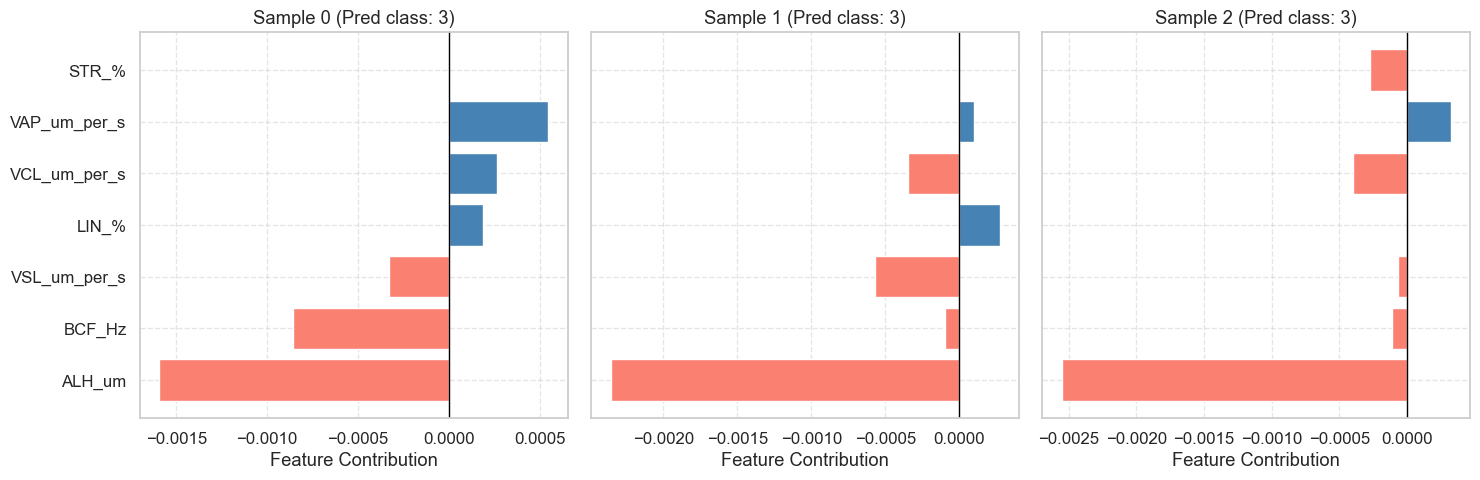

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load LIME data ---
data = {
    'sample_idx': [0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2],
    'pred_class': [3]*18,
    'feature': ['LIN_%','VCL_um_per_s','VSL_um_per_s','VAP_um_per_s','BCF_Hz','ALH_um',
                'BCF_Hz','VAP_um_per_s','LIN_%','VCL_um_per_s','VSL_um_per_s','ALH_um',
                'VSL_um_per_s','BCF_Hz','STR_%','VAP_um_per_s','VCL_um_per_s','ALH_um'],
    'contribution': [0.0001875,0.0002646,-0.0003284,0.0005468,-0.0008563,-0.0015933,
                     -9.8e-05,9.98e-05,0.0002728,-0.0003482,-0.0005702,-0.0023581,
                     -6.62e-05,-0.0001077,-0.0002735,0.0003263,-0.0003950,-0.0025512]
}

df = pd.DataFrame(data)

# --- Plot setup ---
sns.set(style="whitegrid", font_scale=1.1)
samples = df['sample_idx'].unique()
n_samples = len(samples)
fig, axes = plt.subplots(1, n_samples, figsize=(5*n_samples, 5), sharey=True)

if n_samples == 1:
    axes = [axes]

# --- Create per-sample horizontal barplots ---
for ax, s in zip(axes, samples):
    temp = df[df['sample_idx'] == s].sort_values('contribution', ascending=True)
    colors = temp['contribution'].apply(lambda x: 'steelblue' if x > 0 else 'salmon')
    ax.barh(temp['feature'], temp['contribution'], color=colors)
    ax.set_title(f"Sample {s} (Pred class: {temp['pred_class'].iloc[0]})")
    ax.set_xlabel("Feature Contribution")
    ax.axvline(0, color='black', linewidth=1)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

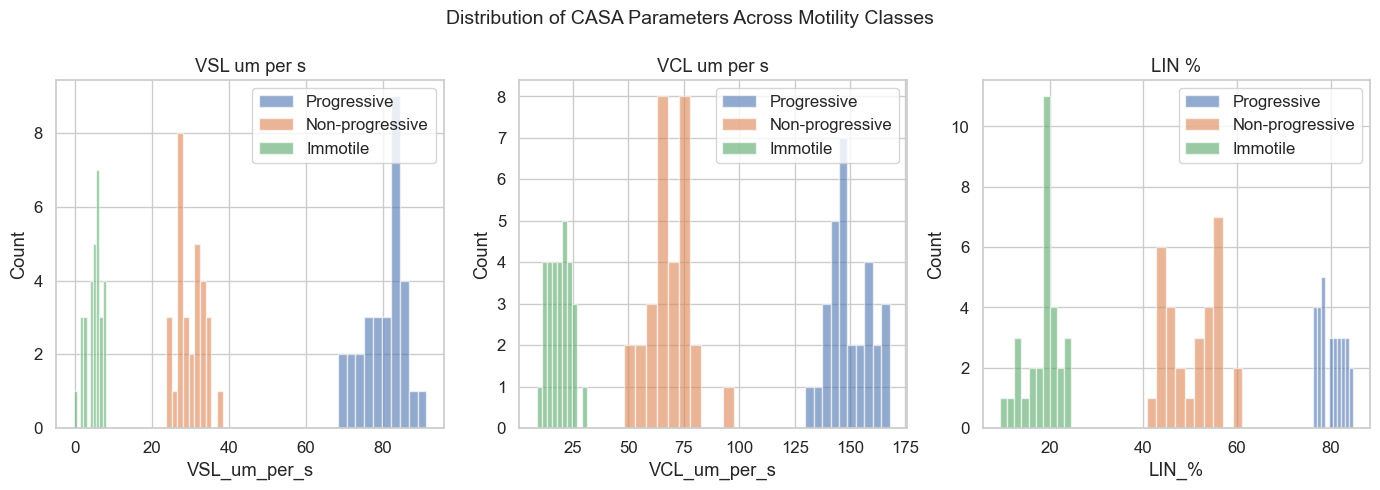

In [3]:
# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Example CASA dataset (replace with your actual data) ---
casa_data = pd.DataFrame({
    'Class': ['Progressive']*30 + ['Non-progressive']*30 + ['Immotile']*30,
    'VSL_um_per_s': [80+5*np.random.randn() for _ in range(30)] +
                    [30+5*np.random.randn() for _ in range(30)] +
                    [5+2*np.random.randn() for _ in range(30)],
    'VCL_um_per_s': [150+10*np.random.randn() for _ in range(30)] +
                    [70+10*np.random.randn() for _ in range(30)] +
                    [20+5*np.random.randn() for _ in range(30)],
    'LIN_%': [80+3*np.random.randn() for _ in range(30)] +
             [50+5*np.random.randn() for _ in range(30)] +
             [20+4*np.random.randn() for _ in range(30)]
})

# --- Plot distributions ---
plt.figure(figsize=(14, 5))

for i, param in enumerate(['VSL_um_per_s', 'VCL_um_per_s', 'LIN_%']):
    plt.subplot(1, 3, i+1)
    for c in casa_data['Class'].unique():
        subset = casa_data[casa_data['Class'] == c]
        plt.hist(subset[param], bins=10, alpha=0.6, label=c)
    plt.title(param.replace('_', ' '))
    plt.xlabel(param)
    plt.ylabel('Count')
    plt.legend()

plt.suptitle('Distribution of CASA Parameters Across Motility Classes', fontsize=14)
plt.tight_layout()
plt.show()